In [22]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pybedtools import BedTool
import bioframe as bf

In [23]:
#open wgs peaks annotated to EGFR exon regions and rename headers
wgs_peaks_AA = pd.read_table('path.txt', header=None, skiprows=1)
wgs_peaks_columns_new = ['PeakID', 'chrom', 'start', 'end', 'strand', 'peak score', 'focusratio', 'annotation', 'detailed annot', 'distTSS', 'gap', 'gap', 'gap', 'Nearest ReqSeq', 'Nearest Ensembl', 'Gene', 'Gene Alias', 'Gene Descrp', 'Gene Type', 'E26_CL']
wgs_peaks_AA.rename(columns=dict(zip(wgs_peaks_AA.columns, wgs_peaks_columns_new)), inplace=True)

#open RNA peaks annotated to EGFR exons, rename the headers and add a row for exon size
rna_egfr_exons = pd.read_table('path.txt', header=None, skiprows=1) 
rna_egfr_exons_new = ['PeakID', 'chrom', 'start', 'end', 'strand', 'peak score', 'focusratio', 'annotation', 'detailed annot', 'distTSS', 'gap', 'gap', 'gap', 'Nearest ReqSeq', 'Nearest Ensembl', 'Gene', 'Gene Alias', 'Gene Descrp', 'Gene Type', 'E26_exon', 'E28_exon']
rna_egfr_exons.rename(columns=dict(zip(rna_egfr_exons.columns, rna_egfr_exons_new)), inplace=True)
rna_egfr_exons['exon_size']=rna_egfr_exons['end']-rna_egfr_exons['start']

In [24]:
#wgs_peaks_AA['E26_CN_block']=wgs_peaks_AA['E26_CL']/wgs_peaks_AA['E26_B']
wgs_peaks_AA['region_size']=wgs_peaks_AA['end']-wgs_peaks_AA['start']
wgs_peaks_AA['counts_per_region']=wgs_peaks_AA['E26_CL']

In [25]:
#annotate whether wgs_peaks_AA is chrom or ecDNA
block_number = pd.Series(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28'], index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27])
wgs_peaks_AA_sort = wgs_peaks_AA.sort_values(['start']).reset_index(drop=True)
wgs_peaks_AA_sort_set = wgs_peaks_AA_sort[['chrom', 'start','end']]
#wgs_peaks_AA_sort

In [26]:
#naming blocks as either chromosomal or ecDNA in a cell line with AA-predicted EGFR exon 2-7 deletion in ecDNA
wgs_peaks_AA_sort['block_number'] = block_number.values
wgs_peaks_AA_sort['block_type']='ecDNA'
blocks_chrom=['2','3','4','5','6','7']
wgs_peaks_AA_sort.loc[wgs_peaks_AA_sort['block_number'].isin(blocks_chrom), 'block_type']='chrom'

In [27]:
#calculate copy number per AA block and abbreviate the columns
wgs_peaks_AA_blocks = wgs_peaks_AA_sort[['chrom','start','end','E26_CL','counts_per_region','block_number','block_type', 'region_size']]

In [28]:
#merge wgs_peaks_AA_blocks with rna_egfr_exons to combine WGS and RNA-seq data
combined_overlap = bf.overlap(wgs_peaks_AA_blocks, rna_egfr_exons, how='right', suffixes=('_1', '_2'))
combined_overlap_brief = combined_overlap[['counts_per_region_1', 'block_number_1','block_type_1', 'E26_exon_2', 'start_2', 'end_2','exon_size_2']]
#combined_overlap_brief

In [18]:
#calculate the RNA:DNA ratio for each EGFR exon (RNA/WGS)
combined_overlap_brief['RNA_DNA_ratio']=combined_overlap_brief.loc[:,'E26_exon_2']/combined_overlap_brief.loc[:,'counts_per_region_1']
#combined_overlap_brief

<ipython-input-18-b31f78a93d19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_overlap_brief['RNA_DNA_ratio']=combined_overlap_brief.loc[:,'E26_exon_2']/combined_overlap_brief.loc[:,'counts_per_region_1']


In [20]:
#To save output to csv
combined_overlap_brief.to_csv('Annotated_peaks_AA_exons201_WGS_RNA_only.csv')

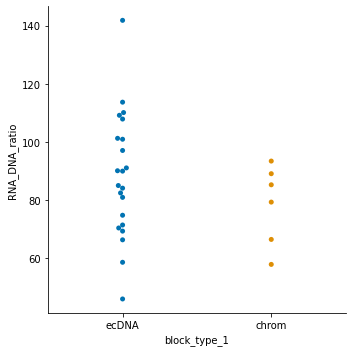

In [21]:
#in-python graphical representation of result
g = sns.catplot(data=combined_overlap_brief, x='block_type_1', y='RNA_DNA_ratio', kind = 'swarm', palette ='colorblind')
g.savefig('E26_merged_exons_only.png', dpi=300)